Importing packages

In [1]:
import pandas as pd
import MyTree as T
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
import seaborn as sns
import warnings

Defining functions

In [2]:
def splitDataframe(df: pd.DataFrame, rate=0.75):
    
    dfScarce3 = df[df['class'] == 3]
    dfScarce4 = df[df['class'] == 4]
    dfScarce8 = df[df['class'] == 8]
    train = df[df['class'] > 4]
    train = train[train['class'] < 8]

    train = train.sample(frac=rate)
    val = df.drop(train.index)
    trainScarce3 = dfScarce3.sample(frac=rate)
    valScarce3 = dfScarce3.drop(trainScarce3.index)
    trainScarce4 = dfScarce4.sample(frac=rate)
    valScarce4 = dfScarce4.drop(trainScarce4.index)
    trainScarce8 = dfScarce8.sample(frac=rate)
    valScarce8 = dfScarce8.drop(trainScarce8.index)

    train = train.append(trainScarce3)
    train = train.append(trainScarce4)
    train = train.append(trainScarce8)
    val = val.append(valScarce3)
    val = val.append(valScarce4)
    val = val.append(valScarce8)
    return train, val
    
    """ 
    unique = df['class'].unique()
    dfStrats = []
    for value in unique:
        dfStrats.append(df[df['class'] == value])
    
    train = dfStrats[0].sample(frac=rate)
    val = dfStrats[0].drop(train.index)
    for i in range(len(unique)):
        if i != 0:
            trainTmp = dfStrats[i].sample(frac=rate)
            valTmp = dfStrats[i].drop(trainTmp.index)
            train = train.append(trainTmp)
            val = val.append(valTmp)
    return train, val
     """

The function above is for splitting a single dataframe into one dataframe for training and one dataframe for validation.

Simple stratification is used for class 3, 4, 8 because they are more scarce compared to class 5, 6, 7

In [3]:
def report(predictions, y_test):
    print('Accuracy: %s' % accuracy_score(y_test, predictions))
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, predictions))
    print('Classification Report:')
    print(classification_report(y_test, predictions))

This function above is for outputing evaluation metrics.

After defining the functions, I first read in the training data.

In [4]:
dfx = pd.read_excel("Dataset1_train/X_train.xlsx")
dfy = pd.read_excel("Dataset1_train/y_train.xlsx")
df = dfx.join(dfy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023 entries, 0 to 1022
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         958 non-null    float64
 1   volatile_acidity      979 non-null    float64
 2   citric_acid           963 non-null    float64
 3   residual_sugar        984 non-null    float64
 4   chlorides             971 non-null    float64
 5   free_sulfur_dioxide   966 non-null    float64
 6   total_sulfur_dioxide  978 non-null    float64
 7   density               977 non-null    float64
 8   pH                    965 non-null    float64
 9   sulphates             972 non-null    float64
 10  alcohol               965 non-null    float64
 11  class                 1023 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 96.0 KB


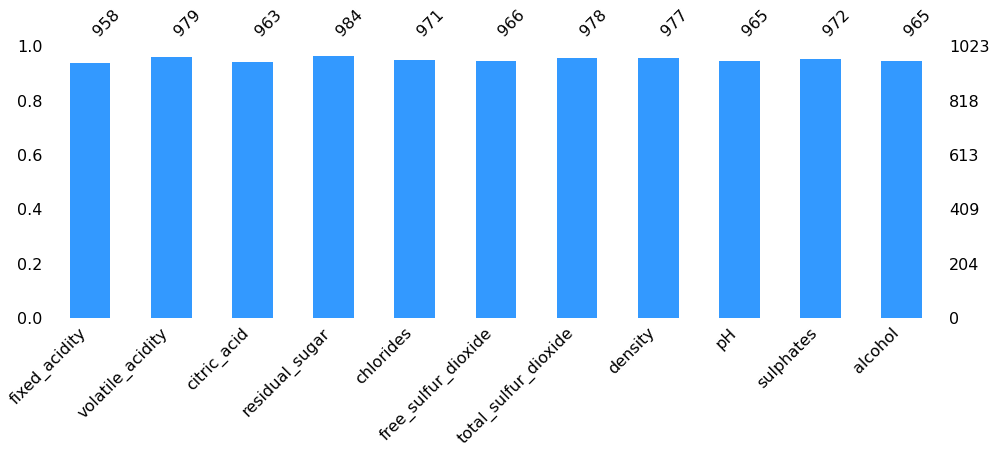

In [5]:
df.info()
msno.bar(dfx, figsize = (16,5), color="#3399FF")
plt.show()

From the info of the dataframe, we can see that all features are continuous features, and that all features contain missing values. From the graph, we can more clearly see this, and we can also see that the missing values aren't a lot.

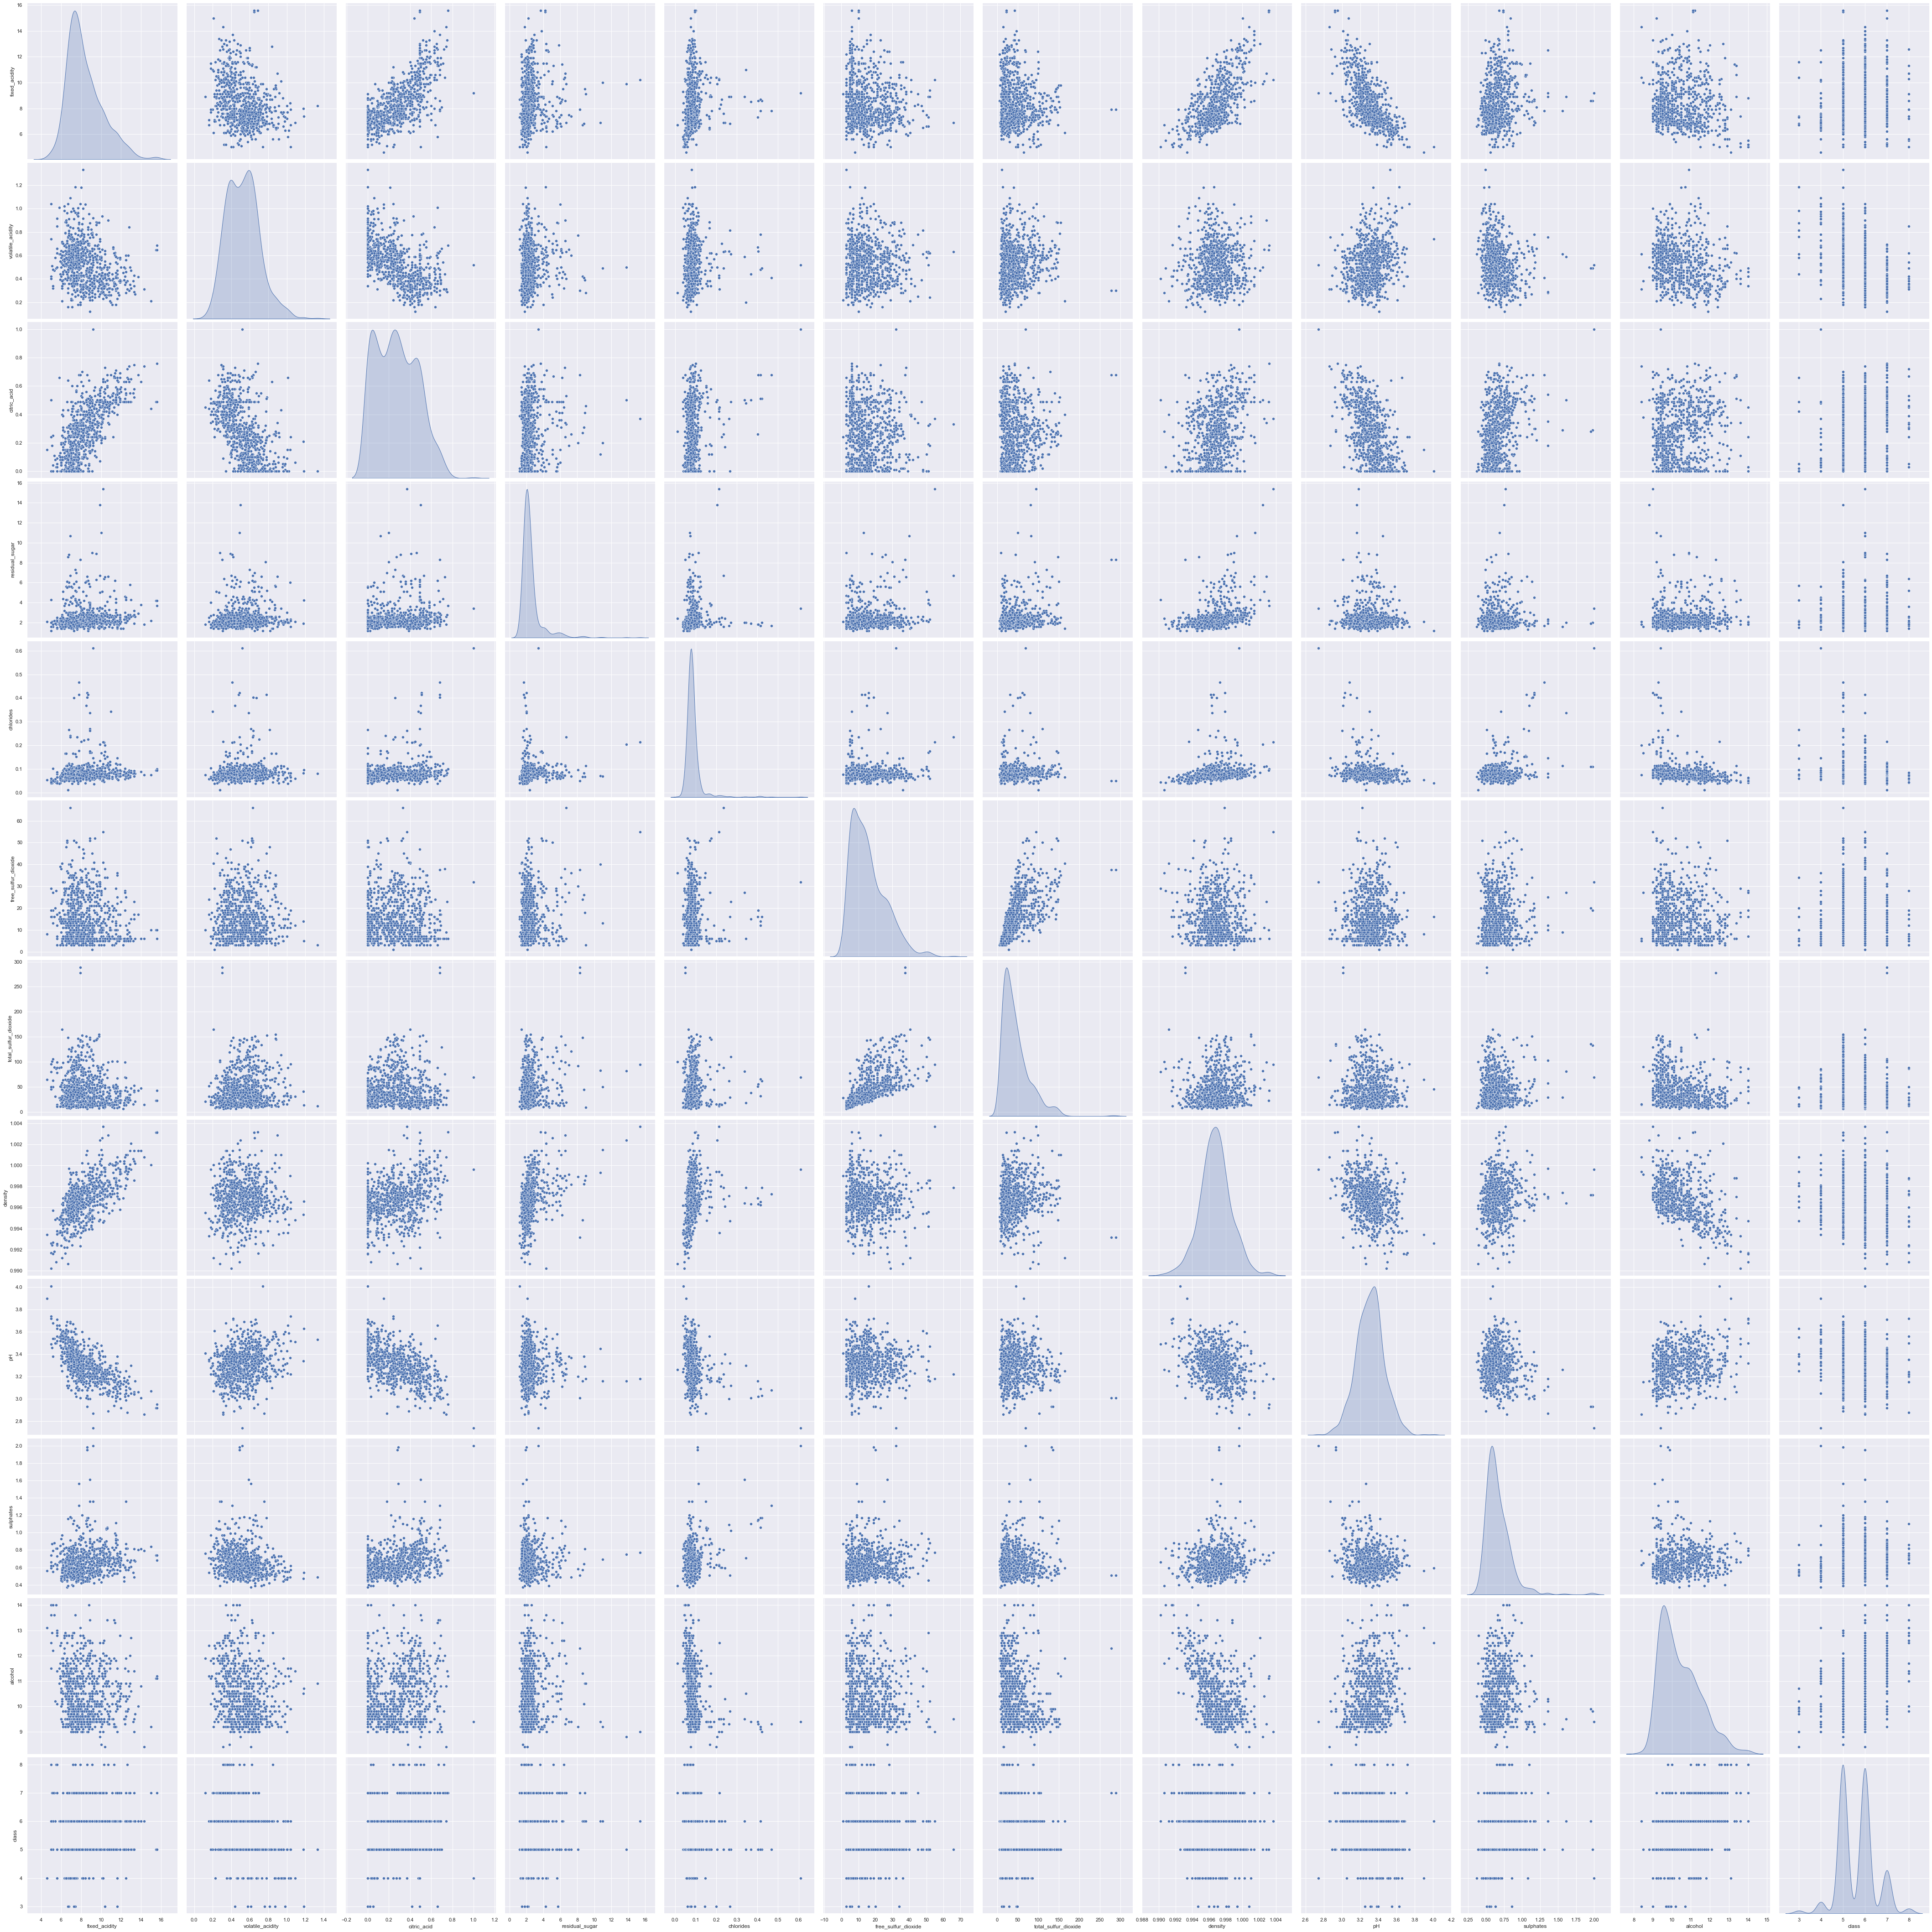

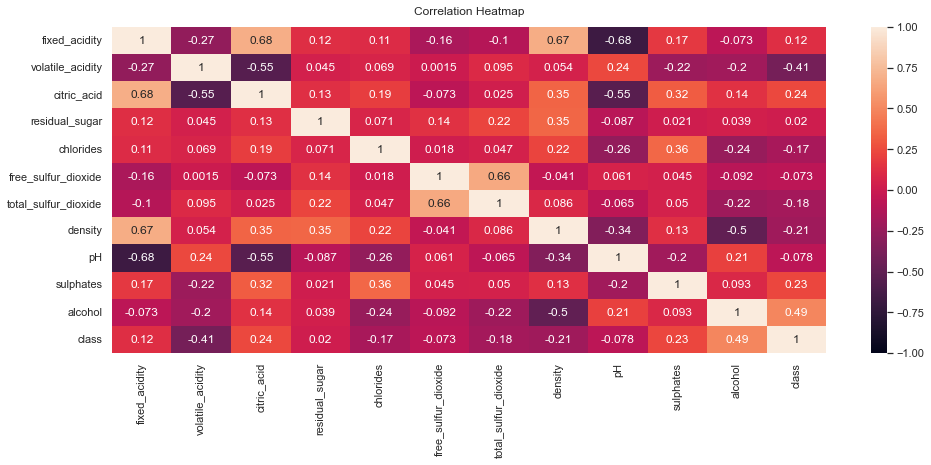

In [6]:
columns=df.columns
sns.set()
sns.pairplot(df[columns],height = 5 ,kind ='scatter',diag_kind='kde')
plt.show()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Above we can see the scatter plot and correlation heat-map of the features and the target class target.
From this, we can observe that the most related pairs of features are quite predictable( for example, the correlation between fixed_acidity and pH).

Since the values of target class have meaning and can be ordered, we can also take a look at the correlation between target class and other features.
From the graph, we can see that the features which have more obvious relations with the target class are alchohol and volatile_acidity.



Text(0.5, 0.98, 'Visualizing continuous columns')

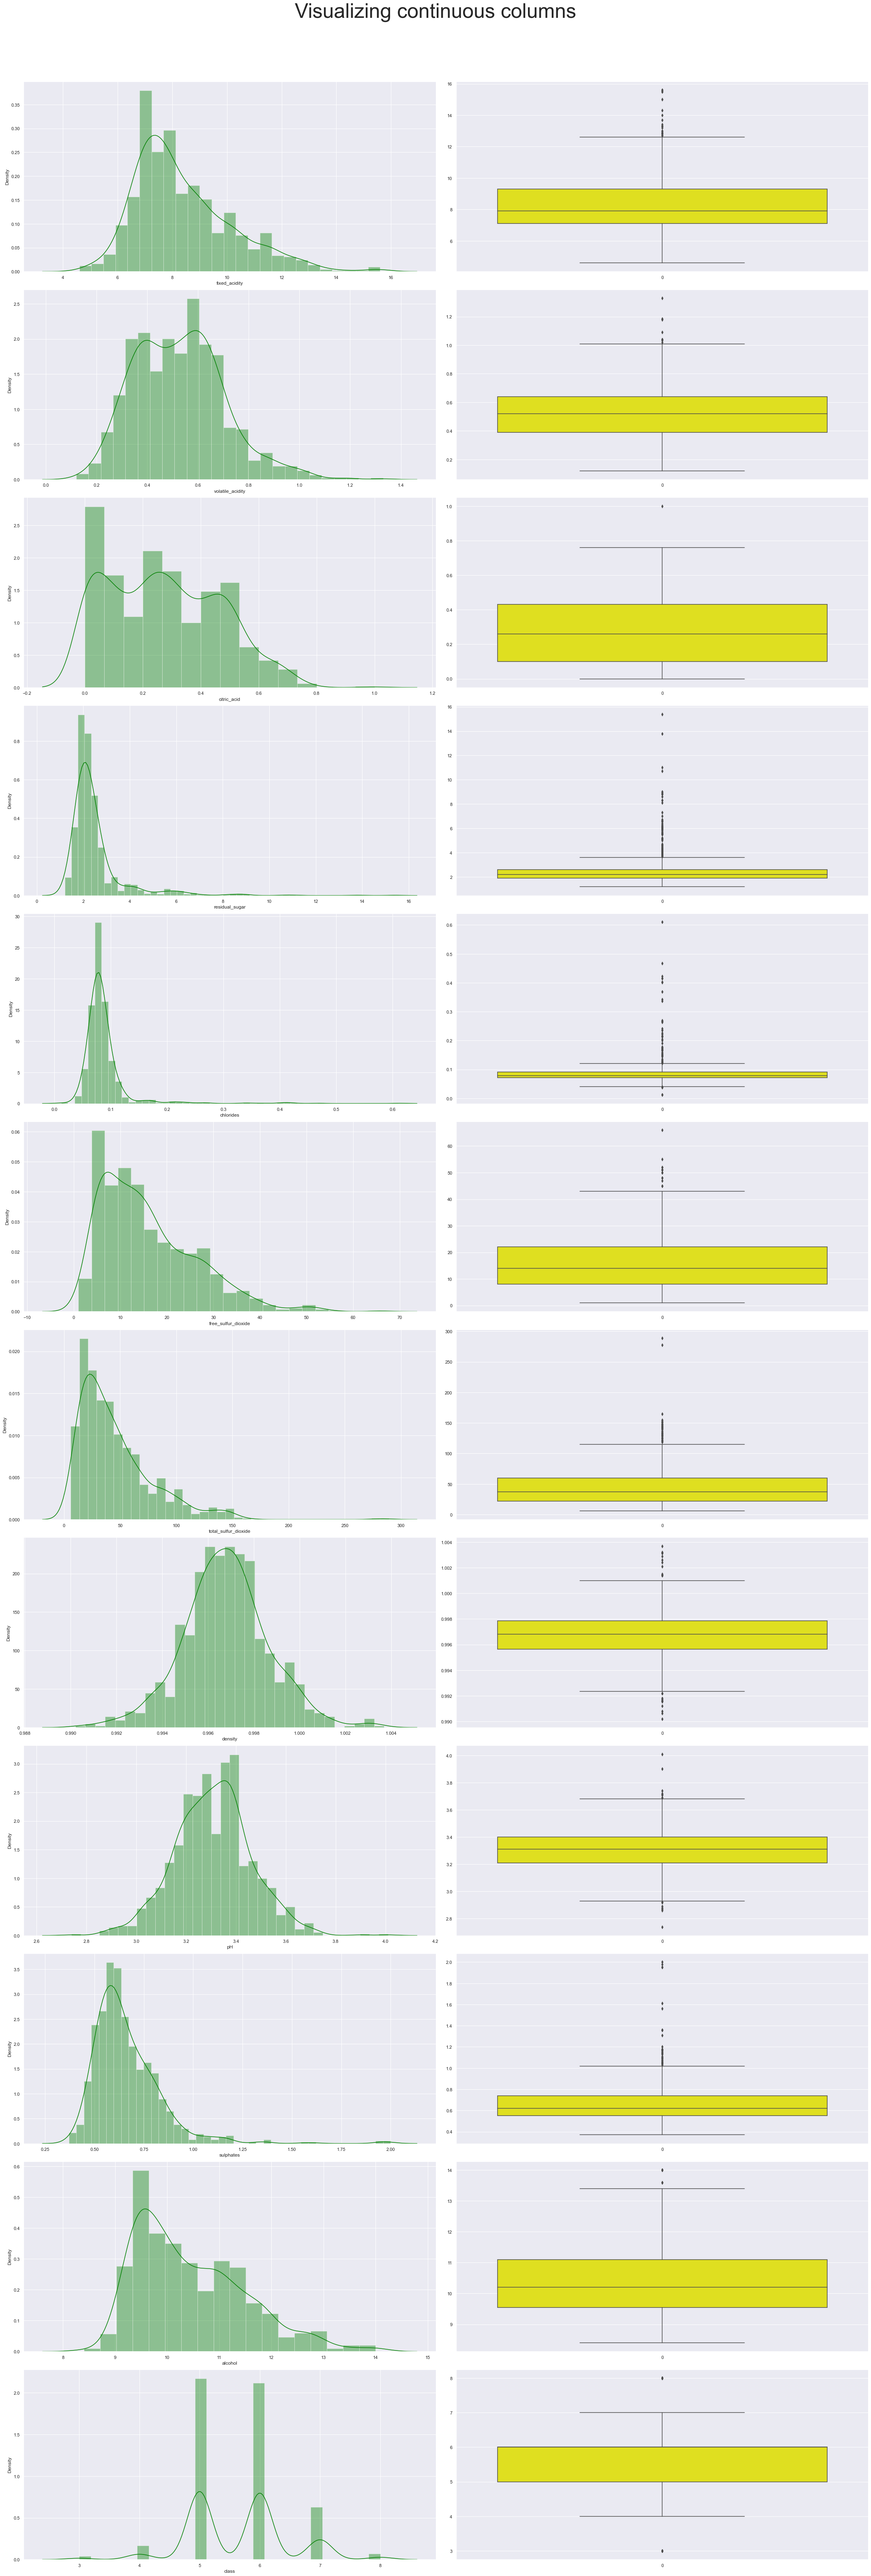

In [7]:
warnings.filterwarnings('ignore')
fig,ax = plt.subplots(12,2,figsize=(30,90))
for index, i in enumerate(df.columns):
    sns.distplot(df[i],ax=ax[index,0],color='green')
    sns.boxplot(df[i],ax=ax[index,1],color='yellow')
    
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle("Visualizing continuous columns",fontsize=50)

Above are the histograms and box plots of the features.
From these graphs, we can see that there exist outliers for some of the features, so it might be better to deal with those values before we fill out the missing values.

In [8]:
""" 
Q1s = []
Q3s = []
ds = []
for d in df.columns:
    if d != 'class':
        Q1 = df[d].quantile(0.25)
        Q3 = df[d].quantile(0.75)
        Q1s.append(Q1)
        Q3s.append(Q3)
        ds.append(d)
dfScarce = df[df['class'] <= 4]
dfScarce.append(df[df['class'] >= 8])
for i in range(len(Q1s)):
    IQR = Q3s[i] - Q1s[i]
    lower_lim = Q1s[i] - 1.5 * IQR
    upper_lim = Q3s[i] + 1.5 * IQR
    out_low = (df[ds[i]] < lower_lim)
    out_up = (df[ds[i]] > upper_lim)
    df = df[(~(out_low | out_up) | df[ds[i]].isnull())]
df = df.append(dfScarce)
df
 """
print('')

Above was the code I used for removing the outliers without affecting missing values.

The lower limit is set to Q1 - 1.5 * interquartile range.
The upper limit is set to Q3 + 1.5 * interquartile range.

However, experiment results show worse performances after performing this, mainly in predicting classes that are more scarce in the original data, I suspect that it's because the outliers are closely tied to target classes that are mroe scarce.

So in the end, I decided to skip this part.

In [9]:
dfTrain, dfVal= splitDataframe(df, rate=0.8)
dfTrain = dfTrain.fillna(dfTrain.median())
dfVal = dfVal.fillna(dfTrain.median())

In [10]:
dfTrain.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count     817.000000        817.000000   817.000000      817.000000   
mean        8.308078          0.524070     0.269761        2.462546   
std         1.705774          0.170273     0.185512        1.203367   
min         4.600000          0.120000     0.000000        1.200000   
25%         7.100000          0.390000     0.100000        1.900000   
50%         7.900000          0.520000     0.255000        2.200000   
75%         9.100000          0.630000     0.410000        2.600000   
max        15.600000          1.330000     1.000000       15.400000   

        chlorides  free_sulfur_dioxide  total_sulfur_dioxide     density  \
count  817.000000           817.000000            817.000000  817.000000   
mean     0.087018            16.155447             45.737454    0.996760   
std      0.042008             9.961922             32.211577    0.001861   
min      0.012000             3.000000              6.000000    0.990200   
25%      0.071000             8.000000             22.000000    0.995700   
50%      0.080000            14.000000             38.000000    0.996800   
75%      0.090000            22.000000             59.000000    0.997820   
max      0.610000            66.000000            278.000000    1.003690   

               pH   sulphates     alcohol       class  
count  817.000000  817.000000  817.000000  817.000000  
mean     3.311432    0.663403   10.435414    5.653611  
std      0.151250    0.175693    1.029108    0.815725  
min      2.740000    0.370000    8.400000    3.000000  
25%      3.210000    0.560000    9.600000    5.000000  
50%      3.310000    0.630000   10.200000    6.000000  
75%      3.400000    0.730000   11.100000    6.000000  
max      4.010000    2.000000   14.000000    8.000000

In [11]:
dfVal.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count     261.000000        261.000000   261.000000      261.000000   
mean        8.380460          0.553927     0.276169        2.634100   
std         1.807644          0.199535     0.203457        1.357099   
min         4.600000          0.180000     0.000000        1.300000   
25%         7.200000          0.400000     0.090000        1.900000   
50%         7.900000          0.530000     0.255000        2.200000   
75%         9.300000          0.660000     0.430000        2.600000   
max        15.500000          1.185000     1.000000       11.000000   

        chlorides  free_sulfur_dioxide  total_sulfur_dioxide     density  \
count  261.000000           261.000000            261.000000  261.000000   
mean     0.087207            14.063218             42.295019    0.996731   
std      0.054246             9.245832             32.319099    0.001898   
min      0.039000             1.000000              7.000000    0.990800   
25%      0.070000             6.000000             20.000000    0.995560   
50%      0.078000            13.000000             34.000000    0.996800   
75%      0.088000            18.000000             51.000000    0.997800   
max      0.610000            51.000000            289.000000    1.003150   

               pH   sulphates     alcohol       class  
count  261.000000  261.000000  261.000000  261.000000  
mean     3.312835    0.657510   10.481418    5.448276  
std      0.154578    0.175364    1.077037    1.161153  
min      2.740000    0.370000    8.400000    3.000000  
25%      3.220000    0.550000    9.600000    5.000000  
50%      3.310000    0.620000   10.200000    5.000000  
75%      3.400000    0.730000   11.100000    6.000000  
max      3.900000    2.000000   14.000000    8.000000

After splitting the original dataframe into one for training and one for validation, I simply filled in the missing values with the median of each feature in the training dataframe because they are all continuous features and from the histograms we can see that some of the features are skewed and there are outliers that would affect the mean.

The missing values in the validation data (as well as the test data used later) is imputed with the median of the training data, because we don't know how the test data are measured, which means we don't know how the missing values occur, so the median of the validation(test) data might not be justifiable.

In [12]:
dInit, tmplist = T.getContFeatures(dfTrain)
dInit

{('alcohol', 8.45),
 ('alcohol', 8.9),
 ('alcohol', 9.05),
 ('alcohol', 9.275),
 ('alcohol', 9.350000000000001),
 ('alcohol', 9.575),
 ('alcohol', 9.649999999999999),
 ('alcohol', 9.75),
 ('alcohol', 9.850000000000001),
 ('alcohol', 9.925),
 ('alcohol', 9.975),
 ('alcohol', 10.01666666665),
 ('alcohol', 10.45),
 ('alcohol', 10.575),
 ('alcohol', 10.850000000000001),
 ('alcohol', 10.95),
 ('alcohol', 11.149999999999999),
 ('alcohol', 11.25),
 ('alcohol', 11.45),
 ('alcohol', 11.850000000000001),
 ('alcohol', 11.95),
 ('alcohol', 12.05),
 ('alcohol', 12.350000000000001),
 ('alcohol', 12.55),
 ('alcohol', 12.649999999999999),
 ('alcohol', 13.05),
 ('alcohol', 13.25),
 ('alcohol', 13.5),
 ('alcohol', 13.8),
 ('chlorides', 0.0385),
 ('chlorides', 0.04),
 ('chlorides', 0.0415),
 ('chlorides', 0.043),
 ('chlorides', 0.045),
 ('chlorides', 0.0475),
 ('chlorides', 0.0495),
 ('chlorides', 0.051000000000000004),
 ('chlorides', 0.0525),
 ('chlorides', 0.0535),
 ('chlorides', 0.0555),
 ('chlorides'

Above I get all features that can be used for splitting the tree. 

Because all features are continuous, we can see that the resulting features are all ([feature], [cutting point])

(refer to the decision tree code documentation for more information on the specifications of these features)

After getting the required attributes to build a tree, I build it with multiple maxDepth values to determine the best one according to their accuracies.

In [13]:
scores = []
for i in range(4):
    tmpTree = T.Tree(dInit, dfTrain)
    tmpTree.build(maxDepth=i + 10)
    tmpPrediction = tmpTree.predict(dfVal.drop(columns=['class']))
    y_true = dfVal['class'].to_numpy()
    y_pred = tmpPrediction['class'].to_numpy()
    scores.append(accuracy_score(y_true, y_pred))
scores = np.array(scores)
print(scores)
bestDepth = scores.argmax() + 10
print(bestDepth)

730 817
729 302
728 170
727 81
726 77
725 16
724 6
723 3
723 3
722 1
722 2
724 10
725 61
724 10
723 2
723 8
722 1
722 7
724 51
723 42
722 20
721 5
720 2
720 3
721 15
722 22
721 4
721 18
720 8
720 10
723 9
722 3
721 2
721 1
722 6
721 5
721 1
726 4
725 1
725 3
727 89
726 31
725 8
724 2
724 6
723 3
722 2
722 1
723 3
725 23
724 17
723 4
723 13
722 11
721 6
721 5
720 3
720 2
722 2
724 6
726 58
725 12
724 2
723 1
723 1
724 10
725 46
724 28
723 10
722 4
721 1
721 3
722 6
723 18
722 13
721 7
720 1
720 6
721 6
720 4
720 2
722 5
721 3
721 2
724 18
723 13
722 7
721 6
721 1
722 6
721 2
721 4
720 2
720 2
723 5
722 3
721 2
721 1
722 2
728 132
727 58
726 22
725 8
724 1
724 7
725 14
724 8
723 2
722 1
722 1
723 6
722 1
722 5
724 6
726 36
725 11
724 5
724 6
723 5
723 1
725 25
724 21
724 4
723 2
723 2
727 74
726 56
725 5
724 4
724 1
725 51
724 34
723 13
722 6
721 3
721 3
722 7
723 21
722 10
721 8
720 1
720 7
721 2
722 11
724 17
723 10
722 2
721 1
721 1
722 8
721 3
720 1
720 2
721 5
723 7
722 6
722 1
726 

In [14]:
decisionTree = T.Tree(dInit, dfTrain)
decisionTree.build(maxDepth=bestDepth)

730 817
729 302
728 170
727 81
726 77
725 16
724 6
723 3
723 3
722 1
722 2
724 10
725 61
724 10
723 2
723 8
722 1
722 7
724 51
723 42
722 20
721 5
720 2
720 3
719 2
719 1
721 15
722 22
721 4
721 18
720 8
719 6
719 2
720 10
719 4
719 6
723 9
722 3
721 2
721 1
722 6
721 5
721 1
726 4
725 1
725 3
727 89
726 31
725 8
724 2
724 6
723 3
722 2
722 1
723 3
725 23
724 17
723 4
723 13
722 11
721 6
721 5
720 3
719 1
719 2
720 2
722 2
724 6
726 58
725 12
724 2
723 1
723 1
724 10
725 46
724 28
723 10
722 4
721 1
721 3
722 6
723 18
722 13
721 7
720 1
720 6
721 6
720 4
720 2
722 5
721 3
721 2
724 18
723 13
722 7
721 6
721 1
722 6
721 2
721 4
720 2
720 2
719 1
719 1
723 5
722 3
721 2
721 1
722 2
728 132
727 58
726 22
725 8
724 1
724 7
725 14
724 8
723 2
722 1
722 1
723 6
722 1
722 5
724 6
726 36
725 11
724 5
724 6
723 5
723 1
725 25
724 21
724 4
723 2
723 2
727 74
726 56
725 5
724 4
724 1
725 51
724 34
723 13
722 6
721 3
721 3
722 7
723 21
722 10
721 8
720 1
720 7
721 2
722 11
724 17
723 10
722 2
721 

In [15]:
prediction = decisionTree.predict(dfVal.drop(columns=['class']))
prediction

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
5              7.4              0.35         0.33             2.4      0.068   
10            10.7              0.40         0.48             2.1      0.125   
12            10.2              0.36         0.64             2.9      0.122   
14            10.2              0.52         0.42             2.0      0.071   
16             8.1              0.66         0.22             2.2      0.069   
..             ...               ...          ...             ...        ...   
899            7.9              0.59         0.49             2.1      0.070   
975            6.8              0.91         0.06             2.0      0.060   
144            9.1              0.40         0.50             1.8      0.071   
237            5.6              0.85         0.05             1.4      0.045   
242           10.3              0.32         0.45             6.4      0.073   

     free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
5                    9.0                  26.0  0.99470  3.31       0.60   
10                  15.0                  49.0  0.99800  3.03       0.81   
12                  10.0                  41.0  0.99800  3.23       0.66   
14                   7.0                  20.0  0.99566  3.31       0.79   
16                   9.0                  23.0  0.99680  3.30       1.20   
..                   ...                   ...      ...   ...        ...   
899                 14.0                  47.0  0.99910  3.30       0.56   
975                  4.0                  11.0  0.99592  3.53       0.64   
144                  7.0                  16.0  0.99462  3.21       0.69   
237                 12.0                  88.0  0.99240  3.56       0.82   
242                  5.0                  13.0  0.99760  3.23       0.82   

     alcohol  class  
5       11.9      6  
10       9.7      5  
12      10.2      5  
14      11.1      6  
16      10.3      5  
..       ...    ...  
899      9.6      3  
975     10.9      5  
144     12.5      6  
237     12.9      6  
242     12.6      6  

[261 rows x 12 columns]

Below are the evaluation metrics of the model with bestDepth and visualizations of its predictions for validation data.

- Various evaluation metrics

In [16]:
y_true = dfVal['class'].to_numpy()
y_pred = prediction['class'].to_numpy()
print(accuracy_score(y_true, y_pred))
report(y_pred, y_true)

0.5747126436781609
Accuracy: 0.5747126436781609
Confusion Matrix:
[[ 6  0  4  0  0  0]
 [ 4 26  8  2  0  0]
 [ 0  4 58 26  2  0]
 [ 0  4 23 41 13  1]
 [ 0  0  1 11  8  2]
 [ 0  0  0  6  0 11]]
Classification Report:
              precision    recall  f1-score   support

           3       0.60      0.60      0.60        10
           4       0.76      0.65      0.70        40
           5       0.62      0.64      0.63        90
           6       0.48      0.50      0.49        82
           7       0.35      0.36      0.36        22
           8       0.79      0.65      0.71        17

    accuracy                           0.57       261
   macro avg       0.60      0.57      0.58       261
weighted avg       0.58      0.57      0.58       261



- Histogram of its predictions

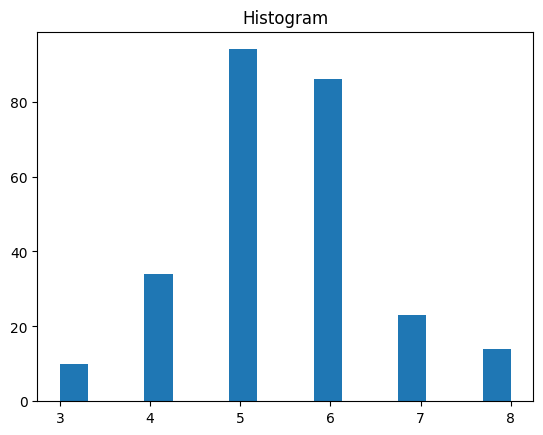

In [17]:
plt.style.use('default')
_ = plt.hist(y_pred, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram")
plt.show()

- Visualized confusion matrix

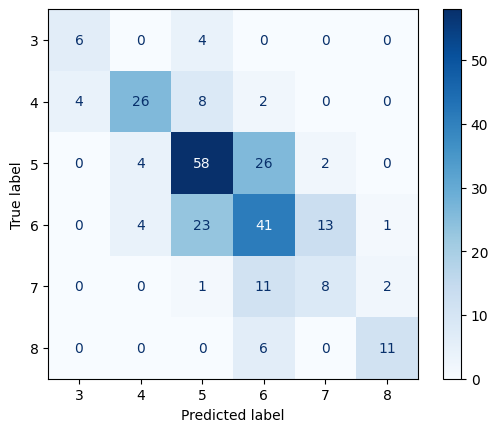

In [18]:
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=([3, 4, 5, 6, 7] if len(cm[0]) == 5 else [3, 4, 5, 6, 7, 8]))

disp.plot(cmap=plt.cm.Blues)
plt.show()

After this I build the final decision tree with bestDepth and the full training dataset and make my final predictions on the provided test data

First I make the final training data, then I read in the test data and fill the missing values with the medians of the training data.

In [19]:
dfFinal= df.fillna(df.median())

In [20]:
dfTest = pd.read_excel("Dataset1_test/X_test.xlsx")

In [21]:
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256 entries, 0 to 255
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         245 non-null    float64
 1   volatile_acidity      243 non-null    float64
 2   citric_acid           244 non-null    float64
 3   residual_sugar        244 non-null    float64
 4   chlorides             247 non-null    float64
 5   free_sulfur_dioxide   242 non-null    float64
 6   total_sulfur_dioxide  244 non-null    float64
 7   density               244 non-null    float64
 8   pH                    246 non-null    float64
 9   sulphates             247 non-null    float64
 10  alcohol               244 non-null    float64
dtypes: float64(11)
memory usage: 22.1 KB


In [22]:
dfTest = dfTest.fillna(df.median())

Below I get the features and train the final decision tree.

In [23]:
dFinal, tmplist = T.getContFeatures(dfFinal)

In [24]:
finalDecisionTree = T.Tree(dFinal, dfFinal)
finalDecisionTree.build(maxDepth=bestDepth)

798 1023
797 382
796 219
795 95
794 49
793 8
792 2
792 6
793 41
792 28
791 11
790 5
789 2
788 1
788 1
789 3
790 6
789 2
789 4
788 3
788 1
791 17
790 15
789 5
789 10
788 4
788 6
787 1
787 5
790 2
792 13
791 2
791 11
794 46
793 6
793 40
792 12
791 3
790 2
790 1
791 9
792 28
791 5
790 1
790 4
791 23
790 16
789 6
788 1
788 5
789 10
788 6
788 4
787 2
787 2
790 7
789 1
789 6
795 124
794 54
793 48
792 45
791 22
790 12
789 7
788 5
788 2
789 5
788 2
788 3
790 10
789 4
788 1
788 3
789 6
791 23
790 1
790 22
789 11
788 6
787 4
787 2
788 5
787 2
787 3
789 11
792 3
793 6
792 5
792 1
794 70
793 38
792 5
791 2
790 1
790 1
791 3
792 33
791 13
790 2
789 1
789 1
790 11
791 20
790 13
789 8
788 4
787 1
787 3
788 4
789 5
790 7
789 6
789 1
793 32
792 10
792 22
791 15
790 6
789 4
788 3
788 1
789 2
790 9
789 6
788 1
788 5
789 3
791 7
790 5
790 2
796 163
795 18
794 12
793 2
792 1
792 1
793 10
792 5
791 2
791 3
792 5
794 6
793 2
793 4
792 1
792 3
795 145
794 131
793 84
792 81
791 73
790 38
789 36
788 14
787 3
78

In [25]:
finalPrediction = finalDecisionTree.predict(dfTest)
finalPrediction['class']

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255


0      5
1      6
2      6
3      6
4      5
      ..
251    5
252    5
253    5
254    5
255    5
Name: class, Length: 256, dtype: int64

In [26]:
finalPrediction['class'].to_excel('Dataset1_test/y_test.xlsx', index=False)
y_pred = finalPrediction['class'].to_numpy()

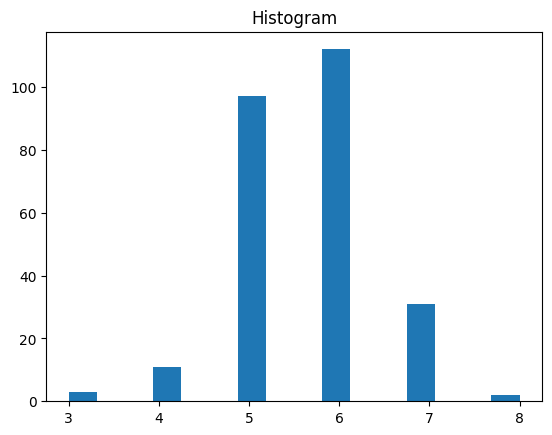

In [27]:
plt.style.use('default')
_ = plt.hist(y_pred, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram")
plt.show()